# Particle Characteristics

Plot distributions of the characteristics of the ash particles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdb
from textwrap import dedent
%matplotlib inline

import os

from travdist import density

# Prepare working directories.  Notebook should be launched from within src directory.
src_dir = '../src'
data_dir = '../data'
plots_dir = '../plots'
os.chdir(src_dir)

In [2]:
def tidy_columns(df):
    """
    Return a copy of the dataframe with cleaned columns and nan rows removed.
    """
    df_tmp = df.copy()
    new_column_names = {
        "Object Voxels": "ObjectVoxels",
        "Convex Voxels": "ConvexVoxels",
        "Object Volume": "ObjectVolume",
        "Convex Volume": "ConvexVolume",
        "Object Surface Area": "ObjectSurfaceArea",
        "Convex Surface Area": "ConvexSurfaceArea",
        "Solidity3D": "Solidity3D",
        "Convexity3D": "Convexity3D",
        "EqDiameter (constant V/A)": "EqDiameter(constantV/A)",
        "EqDiameter (>30 microns)": "EqDiameter(>30microns)",
        "EqDiameter (>60 microns)": "EqDiameter(>60microns)",
        "X": "X",
        "Y": "Y",
        "Z": "Z",
        "Area": "Area",
        "Volume": "Volume",
        "ShapeVa3D": "ShapeVa3D",
        "OrientationPhi": "OrientationPhi",
        "OrientationThetaMin": "OrientationThetaMin",
        "Min": "Min",
        "Max": "Max",
        "Mean": "Mean",
        "Length3D": "Length3D",
        "Width3D": "Width3D",
        "FeretShape3D": "FeretShape3D",
        "EqDiameter": "EqDiameter",
        "HistoPeak": "HistoPeak",
        "SheetName": "SheetName"}

    for column in df.columns:
        # Remove unnecessary columns
        if column not in new_column_names.keys():
            try:
                df_tmp.drop(column, inplace=True)
            except ValueError:
                print("{} not in columns".format(column))
                continue
        
        # Rename columns
        df_tmp.rename(columns=new_column_names, inplace=True)
    
    df_tmp.index.name = 'ParticleID'
    df_tmp.reset_index(inplace=True) 
    
    return df_tmp

def add_extra_parameter_columns(df):
    """
    Return a dataframe with extra columns containing geometrical values
    calculated from the data.
    """
    GLASS_DENSITY = 2300  # kg/m3
    
    xmt = df.copy()
    pixel_diameter = 3  # microns
    xmt['MicronsDiameter'] = xmt['EqDiameter'] * pixel_diameter
    xmt['Sphericity'] = np.pi**(1/3) * ((6 * xmt['ObjectVolume'])**(2/3)) / xmt['ObjectSurfaceArea']
    xmt['ConvexHullSphericity'] = np.pi**(1/3) * ((6 * xmt['ConvexVolume'])**(2/3)) / xmt['ConvexSurfaceArea']
    xmt['EffectiveDensity'] = GLASS_DENSITY * xmt['Solidity3D']
    xmt['DensityBP2003'] = xmt['MicronsDiameter'].map(lambda x: density.bp2003(1e-6*x))
    
    return xmt

In [3]:
# Read dataframe from Excel sheet
sheets = {'32-64': 'merapi_convex_greyscale_32_64.csv',
          '64-125': 'merapi_convex_greyscale_64_125.csv',
          '125-250': 'merapi_convex_greyscale_125_250.csv'}
sheet_data = []
for name, path in sheets.items():
    df = pd.read_csv(os.path.join(data_dir, path), usecols=range(26), index_col=0, na_values=['Err:512'])
    df['SheetName'] = name
    df = tidy_columns(df)
    df = df.dropna(how='all')
    sheet_data.append(df)
    
xmt = pd.concat(sheet_data)
xmt = add_extra_parameter_columns(xmt)
xmt.to_csv(os.path.join(data_dir, 'xmt.csv'), index=False)

/home/jsteven5/Modelling/Pankhurst_XMT/ash_settling_XMT/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  del sys.path[0]


### Exploratory plots of data

In [4]:
xmt = pd.read_csv(os.path.join(data_dir, 'xmt.csv'))

### Plot histograms

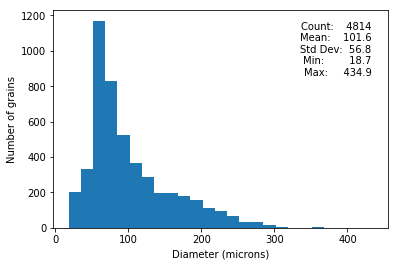

In [5]:
# Histogram of diameters
ax = xmt['MicronsDiameter'].plot.hist(bins=25)
ax.set_xlabel('Diameter (microns)')
ax.set_ylabel('Number of grains')
stats_text = """Count:  {:>6d}
                Mean:    {:5.1f}
                Std Dev: {:5.1f}
                Min:       {:5.1f}
                Max:     {:5.1f}""".format(xmt['MicronsDiameter'].size, xmt['MicronsDiameter'].mean(),
                                      xmt['MicronsDiameter'].std(), xmt['MicronsDiameter'].min(),
                                      xmt['MicronsDiameter'].max())
ax.text(0.95, 0.95, dedent(stats_text), horizontalalignment='right', verticalalignment='top',
        transform=ax.transAxes)

plt.savefig(os.path.join(plots_dir, 'Merapi_MicronsDiameter_Hist.png'), bbox_inches='tight', dpi=150)

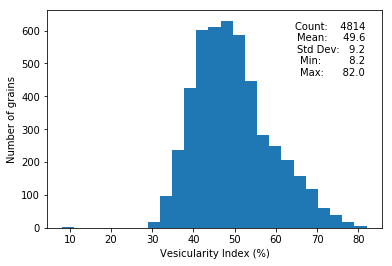

In [6]:
# Histogram of vesicularity (this is equivalent to 100 * (1-solidity))
xmt['VesicularityIndex'] = 100 * (1 - xmt['Solidity3D'])
ax = xmt['VesicularityIndex'].plot.hist(bins=25)
ax.set_xlabel('Vesicularity Index (%)')
ax.set_ylabel('Number of grains')
stats_text = """Count:  {:>6d}
                Mean:    {:5.1f}
                Std Dev: {:5.1f}
                Min:       {:5.1f}
                Max:     {:5.1f}""".format(xmt['VesicularityIndex'].size, xmt['VesicularityIndex'].mean(),
                                      xmt['VesicularityIndex'].std(), xmt['VesicularityIndex'].min(),
                                      xmt['VesicularityIndex'].max())
ax.text(0.95, 0.95, dedent(stats_text), horizontalalignment='right', verticalalignment='top',
        transform=ax.transAxes)

plt.savefig(os.path.join(plots_dir, 'Merapi_VesicularityIndex_Hist.png'), bbox_inches='tight', dpi=150)

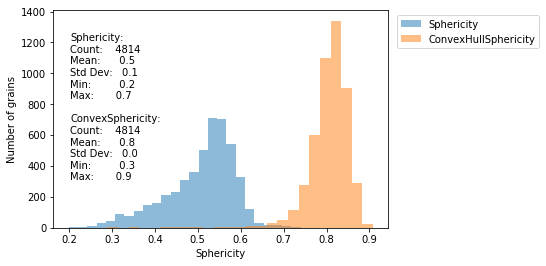

In [7]:
# Histogram of sphericity (both for raw particle and for convex hull)
ax = xmt['Sphericity'].plot.hist(bins=25, alpha=0.5)
xmt['ConvexHullSphericity'].plot.hist(bins=25, alpha=0.5, ax=ax)
ax.set_xlabel('Sphericity')
ax.set_ylabel('Number of grains')
stats_text = """
                Sphericity:
                Count:  {:>6d}
                Mean:    {:5.1f}
                Std Dev: {:5.1f}
                Min:       {:5.1f}
                Max:     {:5.1f}
                
                ConvexSphericity:
                Count:  {:>6d}
                Mean:    {:5.1f}
                Std Dev: {:5.1f}
                Min:       {:5.1f}
                Max:     {:5.1f}
                """.format(xmt['Sphericity'].size, xmt['Sphericity'].mean(),
                           xmt['Sphericity'].std(), xmt['Sphericity'].min(),
                           xmt['Sphericity'].max(), xmt['ConvexHullSphericity'].size,
                           xmt['ConvexHullSphericity'].mean(), xmt['ConvexHullSphericity'].std(),
                           xmt['ConvexHullSphericity'].min(), xmt['ConvexHullSphericity'].max())
ax.text(0.05, 0.95, dedent(stats_text), horizontalalignment='left', verticalalignment='top',
        transform=ax.transAxes)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

plt.savefig(os.path.join(plots_dir, 'Merapi_Sphericity_Hist.png'), bbox_inches='tight', dpi=150)

### Plot distribution of size versus solidity

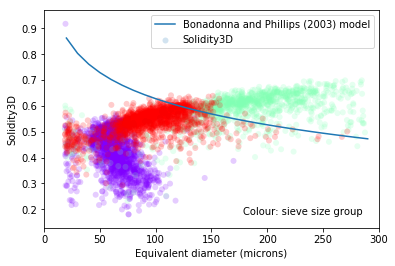

In [8]:
# Assign a different number to each source data file, so they can be converted into colours
def get_source_data_file_numbers(source_data_file_list):
    number = 0
    source_data_file_numbers = [number]
    for i in range(1, len(xmt)):
        if source_data_file_list[i] != source_data_file_list[i - 1]:
            number += 1
        source_data_file_numbers.append(number)
    return source_data_file_numbers

xmt['SheetName'] = get_source_data_file_numbers(xmt['SheetName'].tolist())


# Size versus vesicularity
fig = plt.figure()
ax = plt.scatter(xmt['MicronsDiameter'], xmt['Solidity3D'], c=xmt['SheetName'], cmap='rainbow',
                alpha=0.2, linewidth=0)
plt.text(0.95, 0.05, 'Colour: sieve size group',
         horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)

# Add curve for Bonadonna and Phillips 2003
d_microns = np.arange(20, 300, 10)
d = d_microns / 1000000.0
modelled_densities = [density.bp2003(x) for x in d]
solidity = density.convert_to_solidity(modelled_densities)
plt.plot(d_microns, solidity, label='Bonadonna and Phillips (2003) model')
plt.xlabel('Equivalent diameter (microns)')
plt.ylabel('Solidity3D')
plt.xlim(0, 300)
plt.legend()

plt.savefig(os.path.join(plots_dir, 'Merapi_EqDiameter_vs_Solidity_withBP2003.png'), bbox_inches='tight', dpi=150)

(0, 300)

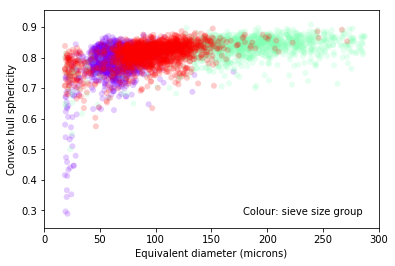

In [9]:
# Size versus convex hull sphericity
fig = plt.figure()
ax = plt.scatter(xmt['MicronsDiameter'], xmt['ConvexHullSphericity'], c=xmt['SheetName'], cmap='rainbow',
                alpha=0.2, linewidth=0)
plt.text(0.95, 0.05, 'Colour: sieve size group',
         horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)
plt.xlabel('Equivalent diameter (microns)')
plt.ylabel('Convex hull sphericity')
plt.xlim(0, 300)

(0, 300)

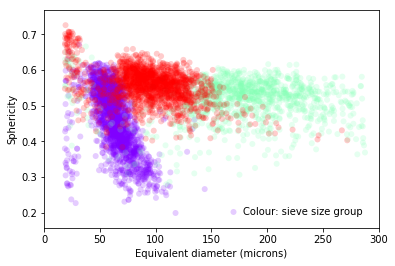

In [10]:
# Size versus sphericity
fig = plt.figure()
ax = plt.scatter(xmt['MicronsDiameter'], xmt['Sphericity'], c=xmt['SheetName'], cmap='rainbow',
                alpha=0.2, linewidth=0)
plt.text(0.95, 0.05, 'Colour: sieve size group',
         horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)
plt.xlabel('Equivalent diameter (microns)')
plt.ylabel('Sphericity')
plt.xlim(0, 300)